<img src="https://brand.umich.edu/assets/brand/style-guide/logo-guidelines/U-M_Logo-Horizontal-Hex.png" alt="Drawing" style="width: 300px;" align="left"/><br>

## Week 3: Predictive Model
 
Predictive models are tools that, when developed and implemented well, help in accomplishing a task. By task, we mean more than merely making predictions; we mean using predictions to either allocate resources differently (i.e., prioritize) or recommend one course of action over another for a learner (i.e., personalize). Thus, prior to building any model, we need to answer an important question: Would I do something differently if two learners had different predicted scores? One evidence-based strategy that we want to deploy differently to different students is a brief check-in routine. This routine is comprised of setting up a meeting time with a student, identifying where they are struggling, and helping them in both building their confidence that they can overcome struggle and providing them with specific strategies for doing so.
 
If a learning analytics project has a need to prioritize or personalize, then the question becomes, can I predict the negative outcome that the new prioritization of resources or personalized strategy is intended to subvert? In this Notebook, we are going to develop a model to identify students who are at risk of failing the course. Given the number of students in the course, a model could potentially help in identifying which students to have a "check-in" conversation with. For this initial model, we will constrain the timeframe from which we will make our prediction to on or before **day 60** in the course. We are aligning our prediction window with the needs of a typical course instructor, which include a prioritized list of students to reach out to approximately 25% of the way into the course.

### Dictionary
- **student_info.csv**
    - **id_student** = numeric; unique identifier for each student in the course
    - **gender** = character; M = "male", F = "female"
    - **highest_education** = character; “Some Graduate”, “Some Higher Education”, “High School + Advanced Placement”, “High School”, “No Formal Quals” (Categories ordered from highest documented education level attained to lowest documented education level attained)
    - **disability** = character; Y = "yes", N = "no"
    - **final_result** = character; "Fail", "Pass"


- **quizzes_tests.csv**
    - **id_student** = numeric; unique identifier for each student in the course
    - **assignment_name** = character; name of graded assignment (Quiz 1-7, Test 1-6, Final Exam)
    - **due_date** = numeric; date assignment was due (indexed as count in days from start of course, i.e., day 0)
    - **weight** = numeric; weight multiplied by score when generating final grade (weight * score / 100)
    - **date_submitted** = numeric; date student submitted assigned (indexed as count in days from start of course, i.e., day 0, NaN means students did not submit assignment)
    - **score** = numeric; score student earned on assignment (0 means students did not submit assignment)


- **learning_resources.csv**
    - **id_student** = numeric; unique identifier for each student in the course
    - **activity_type** = character; overarching label for learning activity students can access (“course_homepage”, “course_page”, “forum”, ‘resource”, “wiki”)
    - **activity_id** = numeric; unique identifier for specific learning activity student accessed within overacting `activity_type`
    - **date** = numeric; date student accessed specific `acitivity_id`  (indexed as count in days from start of course, i.e., day 0)
    - **sum_click** = numeric; count of clicks for `activity_id` on date

In [100]:
!pip install imblearn

In [261]:
import pandas as pd
import numpy as np

# Choose your classifier!
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Packages that will help
from scipy.interpolate import interp1d
from sklearn import preprocessing, linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, scale
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from imblearn.pipeline import make_pipeline
#from sklearn.linear_model import LinearRegressionCV
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import seaborn as sns
import re
import sklearn
from numpy import sqrt
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import r2_score, log_loss, roc_auc_score, accuracy_score, auc, DetCurveDisplay, RocCurveDisplay, f1_score, roc_curve

In [199]:
lr = pd.read_csv('assets/learning_resources.csv')
qt = pd.read_csv('assets/quizzes_tests.csv')
si = pd.read_csv('assets/student_info.csv')

## 1. Wrangle (10 points)

To build your model, you will wrangle all three of datasets. The kind of data wrangling we are looking for in this initial step will involve, first, sub-setting the dataset to not include information beyond day 60. Second, it will involve engineering features within a given dataset.

A lot of feature engineering will need to take place within the `learning_resources.csv` file as it provides a very granular representation of learners' online activity. For example, a reasonable set of features could include "total clicks by resource type." To generate these features will involve using `groupby` and rotating long-form data into wide-form. Your wrangling will be complete when you have joined all three sub-set and engineered files into one flat file.

### Grading

1.1. (2 points) Extract and recode `final_result`

1.2. (3 points) Create two or more features from `quizzes_tests.csv`, with at least one continuous variable

1.3. (3 points) Create two or more features from `learning_resources.csv`, with at least one continuous variable

1.4. (2 points) Join datasets into one flat file

**Note:** Make sure to not include any information from beyond day 60 in the course.

## Student information

Luckily, `student_info.csv`, does not require much wrangling. However, we will want to be mindful about including only actionable features in our model. For example, `gender`, `highest_education`, and `disability` are present in this dataset. These factors are important to understand and explore when users have the opportunity to reflect on an analysis; these kinds of factors, however, can lead to unfair prediction models. For example, it may be useful to know that students with "Some Higher Education" outperform, on average, students whose highest documented education is "High School." This kind of analysis could help administrators better think about the support services they provide to learners. 

When used in a predictive model, however, the average performance gap between these two groups could drive a prediction lower for a student whose highest documented education is "High School" even if she is performing well on quizzes and tests, which are the drivers of student success in the course. In this case, quizzes and tests are more actionable than prior education because both teacher and student can do something different based on these data. Thus for `student_info.csv`, we will only extract `id_student` and `final_result`. Lastly, we will recode `final_result` so that our resulting predictions capture a probability of failing the course.

**Note: You will lose all points for the entire "Wrangle" section if you include** `gender`, `highest_education`, **and/or** `disability`.

1.1. (2 points) Extract and recode `final_result`

In [200]:
si.head()

,id_student,gender,highest_education,disability,final_result
0,41060,M,Some Higher Education,N,Fail
1,45664,M,Some Higher Education,N,Pass
2,52014,F,High School,N,Fail
3,53488,F,Some Higher Education,N,Pass
4,60135,F,High School + Advanced Placement,N,Pass


In [201]:
si.shape

(813, 5)

In [202]:
## Your code with comments
#Recoding the SI data involves removing the gender/highest_education/disability columns to avoid stereotyping, and 
#converting Pass/Fail to 1/0 to allow easier data processing.  A single record was dropped to help allow the data 
#convergence to take place later, which requires all dfs to have the same number of rows.  np.where was used to sort the 
#data by those who failed labeled with a '0', and others who did not fail labeled with a '1'. 

# YOUR CODE HERE
si1 = si[['id_student', 'final_result']]
si1['final_result'] = np.where(si1['final_result']=='Fail', 0, 1)
si1 = si1.drop(812)
si2 = si1.fillna('0')
si2.head 

<bound method NDFrame.head of      id_student  final_result
0         41060             0
1         45664             1
2         52014             0
3         53488             1
4         60135             1
..          ...           ...
807     2677955             1
808     2678338             0
809     2683836             1
810     2689536             1
811     2693243             1

[812 rows x 2 columns]>

In [203]:
#si_ids_selected .shape

In [204]:
#si_ids_selected.head()

In [205]:
#si_ids_selected ['id_student'].dtype

In [206]:
#si_ids_selected ['final_result'].dtype

## Quizzes and tests

The `quizzes_tests.csv` file will require more wrangling as it needs to be both subset and rotated from long to wide. You should also apply the `weight` to `score` to get the most accurate representation for each quiz or test (weight * score / 100).

Possible features include the weighted quiz and test scores, whether or not quizzes and tests were simply turned in, and in addtion to these whether or not quizzes were late or on time.

Key to working with data from before day 60 are two columns, `due_date` and `date_submitted`. Proper subsetting involves starting with `due_date` as it is common for all students for each assignment. Thus, `due_date` gives us an equivalent baseline for all learners (i.e., if an assignment, regardless of when a student completed it, is due on day 65, we won’t include it as that is after day 60). But, since we are working with historical data, there could students in our dataset who turned in an assignment due on or before day 60, but did so **late**. Thus, if we only use `due_date`, we let this data beyond day 60 in, i.e., leakage. Thus, after subsetting by `due_date`, one should then subset by `date_submitted`.

1.2. (3 points) Create two or more features from `quizzes_tests.csv`, with at least one continuous variable

In [207]:
qt.head(20)

,id_student,assignment_name,due_date,weight,date_submitted,score
0,41060,Quiz 1,23,2.0,25.0,77
1,41060,Test 1,25,7.5,24.0,85
2,41060,Quiz 2,51,3.0,54.0,94
3,41060,Test 2,53,10.0,53.0,86
4,41060,Quiz 3,79,3.0,81.0,94
5,41060,Test 3,81,12.5,81.0,90
6,41060,Quiz 4,114,4.0,117.0,97
7,41060,Test 4,116,15.0,116.0,84
8,41060,Quiz 5,149,4.0,152.0,87
9,41060,Test 5,151,15.0,146.0,56


In [208]:
## Your code with comments
# weight-score feature was created using the formula (weight*score)/100
# YOUR CODE HERE

qt['weight-score'] = (qt['weight']*qt['score'])/100
qt.head()

,id_student,assignment_name,due_date,weight,date_submitted,score,weight-score
0,41060,Quiz 1,23,2.0,25.0,77,1.540
1,41060,Test 1,25,7.5,24.0,85,6.375
2,41060,Quiz 2,51,3.0,54.0,94,2.820
3,41060,Test 2,53,10.0,53.0,86,8.600
4,41060,Quiz 3,79,3.0,81.0,94,2.820


In [210]:
#index_col = qt['due_date']
#qt_set = qt.set_index(index_col).sort_index()
#qt_set_60 = qt_set[:60]
#qt_set_60.head()

In [211]:
#Create a categorical column for whether submitted (1) or not (0) and if submitted,
#qt['submitted'] = np.where(qt['date_submitted'].isna(), 0, 1)
#Create a categorical column for delay (1) or not (0) based on date_submitted <= due_date
#qt['submitted_on_time'] = np.where(qt['date_submitted'] <= qt['due_date'], 1, 0)

#qt.head()

In [212]:
# a qt_new df was created to filter the data and only include data from the first 60 days of class.  It was discovered that
# only Quiz 1, Quiz 2, Test 1, and Test 2 were going to be available for test/quiz analysis during this timeframe.  

qt_new = qt.loc[(qt['due_date']<= 60) & (qt['date_submitted'] <= 60)]
qt_new.head()

,id_student,assignment_name,due_date,weight,date_submitted,score,weight-score
0,41060,Quiz 1,23,2.0,25.0,77,1.540
1,41060,Test 1,25,7.5,24.0,85,6.375
2,41060,Quiz 2,51,3.0,54.0,94,2.820
3,41060,Test 2,53,10.0,53.0,86,8.600
14,45664,Quiz 1,23,2.0,25.0,47,0.940


In [213]:
qt_new.shape

(3013, 7)

In [214]:
# A pivot table was created to provide weighted-scores for each Quiz/Test, as well as to combine the students' data into a single
# average score, eliminating the repetitive student id numbers we had earlier

qt_new1 = pd.pivot_table(qt_new, index='id_student', columns='assignment_name', values='weight-score', aggfunc={'weight-score':np.mean}).fillna('0').reset_index()
qt_new1.head()

assignment_name,id_student,Quiz 1,Quiz 2,Test 1,Test 2
0,41060,1.54,2.82,6.375,8.6
1,45664,0.94,0,4.95,4.6
2,52014,1.06,1.59,6.075,7.0
3,53488,1.86,2.91,6.0,6.1
4,60135,1.14,2.58,5.7,7.6


In [215]:
qt_new1.shape

(812, 5)

## Learning resources

The `learning_resources.csv` provides a high degree of flexibility in how to engineer potential features. **Proper subsetting** of this file involves not including any resource beyond `date` <= 60.

1.3 (3 points) Create two or more features from `learning_resources.csv`, with at least one continuous variable

In [216]:
lr.head()

,id_student,activity_type,activity_id,date,sum_click
0,420388,resource,219,0,1
1,420388,course_homepage,1,0,3
2,420388,course_page,87,0,1
3,420388,resource,229,0,2
4,420388,course_page,1,0,2


In [217]:
lr.shape

(443336, 5)

In [218]:
# The first 60 days of data was extracted from the lr dataframe using the 'date' column.

lr_sorted = lr.loc[(lr['date']<=60)]
lr_sorted.head()

,id_student,activity_type,activity_id,date,sum_click
0,420388,resource,219,0,1
1,420388,course_homepage,1,0,3
2,420388,course_page,87,0,1
3,420388,resource,229,0,2
4,420388,course_page,1,0,2


In [219]:
## Your code with comments
# YOUR CODE HERE
# Rearranging the lr dataframe to sort the sum_clicks by activity_type and calculate the sum_click sum for each student
lr_wide_sum_= pd.pivot_table(lr_sorted, index='id_student', columns='activity_type', values='sum_click', aggfunc='sum').fillna('0').reset_index() 
lr_wide_sum_.head()

activity_type,id_student,course_homepage,course_page,forum,resource,wiki
0,41060,37.0,108.0,16.0,19.0,11.0
1,45664,144.0,141.0,107.0,115.0,29.0
2,52014,47.0,43.0,26.0,8.0,20.0
3,53488,173.0,98.0,332.0,65.0,39.0
4,60135,629.0,456.0,456.0,185.0,78.0


In [220]:
lr_wide_sum_.shape

(812, 6)

In [221]:
lr_wide_sum_['wiki'].dtype

dtype('O')

In [222]:
# data had to be converted to the same file type to prevent errors during the df merging.  The file type selected for this
# analysis was 'int64'

lr_wide_sum_['course_homepage'] = lr_wide_sum_['course_homepage'].astype(int)
lr_wide_sum_['course_page'] = lr_wide_sum_['course_page'].astype(int)
lr_wide_sum_['forum'] = lr_wide_sum_['forum'].astype(int)
lr_wide_sum_['resource'] = lr_wide_sum_['resource'].astype(int)
lr_wide_sum_['wiki'] = lr_wide_sum_['wiki'].astype(int)

In [223]:
lr_wide_sum_['wiki'].dtype

dtype('int64')

## Join files

1.4 (2 points) Join datasets into one flat file

In [224]:
## Your code with comments
# Merging the different dataframes created into one single dataframe. A total of three dfs were merged.

# YOUR CODE HERE

data_merged1 = si2.merge(qt_new1, on='id_student', how='left')
data_merged2 = data_merged1.merge(lr_wide_sum_, on='id_student', how='left')

data_merged2.shape

(812, 11)

In [225]:
data_merged2.head()

,id_student,final_result,Quiz 1,Quiz 2,Test 1,Test 2,course_homepage,course_page,forum,resource,wiki
0,41060,0,1.54,2.82,6.375,8.6,37.0,108.0,16.0,19.0,11.0
1,45664,1,0.94,0,4.95,4.6,144.0,141.0,107.0,115.0,29.0
2,52014,0,1.06,1.59,6.075,7.0,47.0,43.0,26.0,8.0,20.0
3,53488,1,1.86,2.91,6.0,6.1,173.0,98.0,332.0,65.0,39.0
4,60135,1,1.14,2.58,5.7,7.6,629.0,456.0,456.0,185.0,78.0


In [226]:
# Dropping the id_student column to prevent the large numbers coming from it from having any effects on our other data.

data_merged3 = data_merged2.drop(['id_student'], axis=1)
data_merged3.head()

,final_result,Quiz 1,Quiz 2,Test 1,Test 2,course_homepage,course_page,forum,resource,wiki
0,0,1.54,2.82,6.375,8.6,37.0,108.0,16.0,19.0,11.0
1,1,0.94,0,4.95,4.6,144.0,141.0,107.0,115.0,29.0
2,0,1.06,1.59,6.075,7.0,47.0,43.0,26.0,8.0,20.0
3,1,1.86,2.91,6.0,6.1,173.0,98.0,332.0,65.0,39.0
4,1,1.14,2.58,5.7,7.6,629.0,456.0,456.0,185.0,78.0


In [227]:
data_merged4 = data_merged3.fillna('0')

In [228]:
data_merged4.columns

Index(['final_result', 'Quiz 1', 'Quiz 2', 'Test 1', 'Test 2',
       'course_homepage', 'course_page', 'forum', 'resource', 'wiki'],
      dtype='object')

In [229]:
# Creating data lists to potentially use for different types of analyses using the machine learning models.

quizzes_tests_list = data_merged4[['Quiz 1', 'Quiz 2', 'Test 1', 'Test 2']]
quizzes_list = data_merged4[['Quiz 1', 'Quiz 2']]
#quizzes_list_df = pd.DataFrame(quizzes_list)
#quizzes_list_60 = quizzes_list[:60]
#quizzes_list_2 = data_merged3[['Quiz 1', 'Quiz 2']]
#quizzes_list_2_60 = quizzes_list_4[:60]
#tests_list = data_merged3[['Test 1', 'Test 2']]
#tests_list_60 = tests_list[:60]
#tests_list_2 = data_merged3[['Test 1', 'Test 2']]
#tests_list_2_60 = tests_list_2[:60]

#all_clicks_list = data_merged3[['course_homepage', 'course_page', 'forum', 'resource', 'wiki']]
#all_clicks_list_60 = all_clicks_list[:60]

#submitted_on_time = data_merged3[['submitted_on_time']]
#submitted_on_time_60 = submitted_on_time[:60]
#submitted = data_merged3[['submitted']]
#submitted_df = pd.DataFrame(submitted)
#submitted_60 = submitted[:60]

# 2. Modeling (30 points)

You should split the original data into an 80/20 split and train two different algorithms. Two algorithms are brought in at the top of the Notebook, `LogisticRegression` and `RandomForestClassifier`, but feel free to integrate others that interest you or that seem well suited to the task. To compare these two classifiers, you will use cross-validation on the training set (i.e., the 80% from the original), with the goal of identifying the classifier with the highest AUC. After identifying the best algorithm, you will fit it to your held out test-set and examine the model's calibration, i.e., the relationship between predicted probabilities and observed failure rates. Finally, you will visualize your predicted probabilities and identify a probability cut-off for checking-in with the highest risk students.

### Grading
2.1. (2 points) Split the original dataset into 80/20 train-test sets

2.2. (5 points) Pre-process continuous variables in a pipeline that avoids data leakage

2.3. (10 points) Develop and compare two different classifiers using cross-validated AUC

2.4. (2 points) Apply best performing classifier to test-set and report AUC

2.5. (5 points) Create calibration curve on test-set

2.6. (4 points) Visualize distribution of predicted probabilities using a box plot or histogram

2.7. (2 points) Identify predicted probability threshold to identify the top 20% highest risk students

2.1. (2 points) Split the original dataset into 80/20 train-test sets

In [230]:
#data_merged3['final_result']

In [231]:
## Your code with comments
# A list of grades and the final pass/fail results being assigned to variables X and y
# YOUR CODE HERE
X = quizzes_list
y = data_merged4['final_result']

In [232]:
X.head()

,Quiz 1,Quiz 2
0,1.54,2.82
1,0.94,0
2,1.06,1.59
3,1.86,2.91
4,1.14,2.58


In [233]:
# An 80-20 train-test-split is performed

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2) 

2.2. (5 points) Pre-process continuous variables in a pipeline that avoids data leakage

**Note:** https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [234]:
## Your code with comments
# YOUR CODE HERE
#list_cols_used = [col for col in X.columns if X[col].dtype != 'category']

In [235]:
preprocessor = preprocessing.StandardScaler()

In [236]:
# A pipeline is created with the variables that are expected to be used for each model to help prevent data leakage 
    
# Use a scaler on continuous variables
pipe_lr = Pipeline(steps=[
        ("preprocessor", preprocessor), ('LogisticRegression', LogisticRegression())
    ])

pipe_rfc = Pipeline(steps=[
        ("preprocessor", preprocessor), ('RandomForestClassifier', RandomForestClassifier())
    ])
   
#impute_cols_transformer = ColumnTransformer(
#    transformers=[
#        # This will return the list_cols_used as the first cols followed by the rest
#        ("col_scaled", col_trans, list_cols_used),
           
#    ],
#    remainder='passthrough',
#)

In [237]:
#X_train_scaled = impute_cols_transformer.fit_transform(X_train)

2.3. (10 points) Develop and compare two different classifiers using cross-validated AUC

**Classifier 1**

In [277]:
# A list of parameters of the first classifier is listed to allow observation of what parameters could be specified and
# diagnosed during gridsearch

# Look at parameters used by our current LR
RFC = RandomForestClassifier()
print('Parameters currently in use:\n')
print(RFC.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [239]:
#def select_features(X_train_scaled, y_train, X_test):
#    # configure to select a subset of features
#    fs = SelectKBest(score_func=f_classif, k=all)
#    # learn relationship from training data
#    fs.fit(X_train_scaled, y_train)
#    # transform train input data
#    X_train_fs = fs.transform(X_train_scaled)
#    # transform test input data
#    X_test_fs = fs.transform(X_test)
#   return X_train_fs, X_test_fs, fs

In [240]:
#The training data was fit to the RandomForestClassifier model, and a cross_val_score was calculated using the training data

RFC_model = pipe_rfc.fit(X_train, y_train)
RFC_score = cross_val_score(RFC_model, X, y, cv=5, scoring='roc_auc')

print('Mean score of %0.5f with a standard deviation of %0.5f' % (RFC_score.mean(), RFC_score.std()))

Mean score of 0.71898 with a standard deviation of 0.02487


In [241]:
## Your code with comments
# A second method for was used for evaluating the test data.  Here a list of parameters were selected, and potential values
# each parameter could be set to were also selected and can be seen in the param_grid.  GridSearchCV was then applied to 
# the model to find the parameter value setup that would provide the most accurate predictions.
# YOUR CODE HERE
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test)

## identify parameters
param_grid = {'bootstrap' : [True], 
              'max_depth' : [1,2,3,4], 
              'max_features' : [1,2,3,4],
              'min_samples_split' : [1,2,3,4],
              'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]}  

# perform grid search
# specify model
RFC = RandomForestClassifier()
grid_searcher = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=folds, n_jobs=-1, verbose=2)
grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=75; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=75; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_featu

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]},
             verbose=2)

In [242]:
# After running GridSearchCV, the best_params_ parameter was called to identify the recommended parameter setup

best_grid = grid_searcher.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 1,
 'max_features': 2,
 'min_samples_split': 3,
 'n_estimators': 75}

In [243]:
# Not sure if this was needed here after the kfold used earlier, but was included with the example models I found so 
# I decided to include it anyways.

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]

1 of KFold 5
1 of KFold 5
1 of KFold 5
1 of KFold 5
1 of KFold 5


In [244]:
# RFC model was used, with the ideal parameters calculated earlier, to predict the ROC_AUC score and create a list 
# of prediction probabilities for future test results according to the data from the previous school year.

#model
RFC = RandomForestClassifier(n_estimators=75, criterion='log_loss', max_depth=1, min_samples_split=2, max_features=2, 
                       bootstrap=True, random_state=42, verbose=2)
RFC.fit(xtr,ytr)
score = roc_auc_score(yvl,RFC.predict(xvl))
print('ROC AUC score:',score)
cv_score.append(score)    
pred_test = RFC.predict_proba(X_test)[:,1]
pred_test_full +=pred_test
i+=1

building tree 1 of 75
building tree 2 of 75
building tree 3 of 75
building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished


**Classifier 2**

In [247]:
# Logistic Regression parameters were identified

# Look at parameters used by our current forest
LR = LogisticRegression()
print('Parameters currently in use:\n')
print(LR.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [156]:
#def select_features(X_train_scaled, y_train, X_test):
#    # configure to select a subset of features
#    fs = SelectKBest(score_func=f_classif, k=all)
#    # learn relationship from training data
#    fs.fit(X_train_scaled, y_train)
#    # transform train input data
#    X_train_fs = fs.transform(X_train_scaled)
#    # transform test input data
#    X_test_fs = fs.transform(X_test)
#    return X_train_fs, X_test_fs, fs

In [248]:
# LR model was developed and ran on the training data

LR_model = pipe_lr.fit(X_train, y_train)
LR_score = cross_val_score(LR_model, X, y, cv=5, scoring='roc_auc')

print('Mean score of %0.5f with a standard deviation of %0.5f' % (LR_score.mean(), LR_score.std()))

Mean score of 0.81279 with a standard deviation of 0.02565


In [249]:
## Your code with comments
# Identifying potential parameters and parameter values to utilize while running LogisticRegression. Using GridSearchCV 
# help with identifying optimal parameter setings
# YOUR CODE HERE
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# identify parameters
param_grid = {'penalty': ['l2', 'none', 'elasticnet'], 
            'l1_ratio' : [0,1], 
            'multi_class' : ['auto', 'ovr', 'multinomial'],
            'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
             'random_state':[0,42],
             'max_iter':[50,75,100,125,150,175,200,225,250,275,300]} 

# perform grid search
# specify model
LR = LogisticRegression()
grid_searcher1 = GridSearchCV(estimator=LR, param_grid=param_grid, cv=folds)
grid_searcher1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'l1_ratio': [0, 1],
                         'max_iter': [50, 75, 100, 125, 150, 175, 200, 225, 250,
                                      275, 300],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l2', 'none', 'elasticnet'],
                         'random_state': [0, 42],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']})

In [250]:
#Identifying the best parameters to utilize
best_grid1 = grid_searcher1.best_params_
best_grid1

{'l1_ratio': 0,
 'max_iter': 50,
 'multi_class': 'auto',
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

In [251]:
# Running a stratifiedkfold.  May or may not be needed after already having a kfold ran earlier

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]

1 of KFold 5
1 of KFold 5
1 of KFold 5
1 of KFold 5
1 of KFold 5


In [252]:
#Running the LR model to calculate the roc_auc_score

#model
LR = LogisticRegression(penalty='none', C=1.0, fit_intercept=True, intercept_scaling=1, 
                         random_state=42, solver='sag', max_iter=50, multi_class='multinomial', 
                         verbose=1, l1_ratio=0)
LR.fit(xtr,ytr)
score = roc_auc_score(yvl,LR.predict(xvl))
print('ROC AUC score:',score)
#cv_score.append(score)    
#pred_test = LR.predict_proba(X_test)[:,1]
#pred_test_full +=pred_test
#i+=1

Epoch 1, change: 1.00000000
Epoch 2, change: 0.20143332
Epoch 3, change: 1.03384322
Epoch 4, change: 0.64716936
Epoch 5, change: 0.43194638
Epoch 6, change: 0.35238556
Epoch 7, change: 0.23655845
Epoch 8, change: 0.17738801
Epoch 9, change: 0.35083103
Epoch 10, change: 0.29519467
Epoch 11, change: 0.04419088
Epoch 12, change: 0.04757109
Epoch 13, change: 0.10720223
Epoch 14, change: 0.13688572
Epoch 15, change: 0.23159094
Epoch 16, change: 0.11264586
Epoch 17, change: 0.12493579
Epoch 18, change: 0.06726536
Epoch 19, change: 0.06247540
Epoch 20, change: 0.02798180
Epoch 21, change: 0.02137783
Epoch 22, change: 0.02098872
Epoch 23, change: 0.00750134
Epoch 24, change: 0.01071958
Epoch 25, change: 0.01113161
Epoch 26, change: 0.00642151
Epoch 27, change: 0.00645662
Epoch 28, change: 0.00264789
Epoch 29, change: 0.00072007
Epoch 30, change: 0.00208108
Epoch 31, change: 0.00361076
Epoch 32, change: 0.00322991
Epoch 33, change: 0.00364542
Epoch 34, change: 0.00246390
Epoch 35, change: 0.001

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


2.4. (2 points) Apply best performing classifier to test-set and report AUC

In [253]:
## Your code with comments
#The best resulting classifier during training was the LogisticRegression(), so we now try applying it to the test data
# YOUR CODE HERE
y_pred = pipe_lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)
roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1])

0.8069752491160398

In [254]:
print('AUC Score for LogisticRegression = 81%')

AUC Score for LogisticRegression = 81%


2.5. (5 points) Create calibration curve on test-set

**Note:** for creating calibration curves, see:
- https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py
- https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html

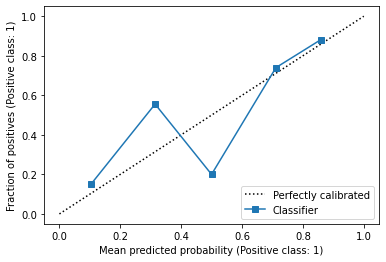

In [255]:
## Your code with comments
# A calibration curve was plotted to assist with observing how well the test data follows a scaler development.  Further 
# distances from the perfectly calibrated line represent lower probabilities of the prediction data being accurate.
# YOUR CODE HERE
prob_true, prob_pred = calibration_curve(y_test, y_pred)
y_prob = pipe_lr.predict_proba(X_test)[:,1]
disp = CalibrationDisplay.from_predictions(y_test, y_prob)
plt.show()

2.6. (4 points) Visualize distribution of predicted probabilities using a box plot or histogram

[Text(0.5, 1.0, 'Predicted Probabilities using Logistic Regression'),
 Text(0.5, 0, 'Mean Predicted Probability'),
 Text(0, 0.5, 'Count')]

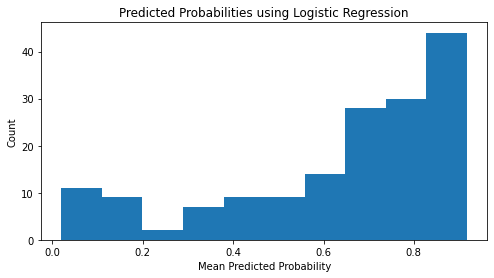

In [256]:
## Your code with comments
# YOUR CODE HERE
fix, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(y_prob)
ax.set(title='Predicted Probabilities using Logistic Regression', 
        xlabel='Mean Predicted Probability',
        ylabel='Count')

2.7. (2 points) Identify predicted probability threshold to identify the top 20% highest risk students

In [270]:
tpr_intrp = interp1d(thresholds, tpr)
print(tpr_intrp(0.7))
#print(tpr_intrp(0.8))

0.9313725490196079


In [271]:
fpr_intrp= interp1d(thresholds, fpr)
print(fpr_intrp(0.7))

0.6327868852459017


In [272]:
thresholds

array([2, 1, 0])

In [273]:
fpr

array([0.        , 0.47540984, 1.        ])

In [274]:
tpr

array([0.        , 0.90196078, 1.        ])

In [279]:
len(y_prob)

163

In [280]:
## Your code with comments
# The top 20% highest risk students have an 80% chance of failing, which is what we sorted the si dataframe by.
# YOUR CODE HERE
high_risk_students = []

y_prob = pipe_lr.predict_proba(X_test)[:, 1]

for prob in range(len(y_prob)):
    if y_prob[prob] <= 0.80:
        high_risk_students.append(prob)

high_risk = data_merged4.iloc[X_test.iloc[high_risk_students].index]
high_risk.head()

,final_result,Quiz 1,Quiz 2,Test 1,Test 2,course_homepage,course_page,forum,resource,wiki
202,1,1.66,2.16,5.025,8.3,227.0,325.0,187.0,99.0,92.0
55,0,0.86,2.58,4.125,6.2,41.0,69.0,21.0,17.0,11.0
478,1,1.34,0,6.075,0,151.0,189.0,31.0,63.0,22.0
14,1,1.4,2.76,6.375,8.2,138.0,211.0,95.0,78.0,23.0
453,0,1.2,2.49,5.775,6.2,335.0,186.0,207.0,109.0,34.0


In [281]:
high_risk.shape

(104, 10)

In [282]:
# 74 future students were predicted to be at risk of failing
len(high_risk[high_risk['final_result']==0])

54

In [283]:
# 89 future students were predicted to pass
len(high_risk[high_risk['final_result']==1])

50

# 3. Interpret (10 points)

After developing the model, moving from wrangling to analyzing the predictions generated by the model, provide your thoughts on the following questions:

3.1. What concerns do you have for deploying the model? Concerns can include model quality based on different evaluation metrics, how well the model captures what it means to be successful in the course, and potential harmful uses of the model. (5 points)

Concerns I have for deploying this model would include whether or not there is another model that exists that could provide a higher accuracy, and the possibility of this model not labeling (or falsely labeling) some students who are struggling and need help.  If a teacher were to mistakingly think that this machine-learning model could predict better than his/her in-person observations, then he/she could rely too much on the machine-learning model and forget to keep an eye-out for the physical actions that suggest a student is struggling.  Mistakingly telling a student that the AI-model predicted he/she will struggle/fail in the future can also have negative implications on the student's mindset during school.  The model seems as if it could definitely use some more tuning to work towards providing a better accuracy.  Some of the students with higher scores can clearly be predicted without machine-learning with a high probability of passing.  Alongside the potential uses of this model, I would also document all the potential pitfalls of this model and how the teachers/staff can work around those pitfalls that could cause inaccurate judgments.  Society can never expect machines to be perfect, but we can utilize their precisions, which is sometimes better than human-precision, to assist us in making better judgments on what direction to head towards next while working towards common goals for the healthier development of education.  Considering how the model predicts 50/163 students to pass and 54/163 students to fail...and typically the amount of students who pass versus fail is nowhere close to a 50/50 ratio...I would really emphasize to the teachers utlizing this model not to fully depend on it, to use it more as a guidance for what students to keep a closer eye on, and to continue practicing development of their natural capabilities to detect when students are struggling.

3.2. Finally, how well do you think the model helps in prioritizing students to support? (5 points)

The model can definitely help give some teachers a chance to evaluate their students better than they may be able to while lacking teaching experience.  It can take a number of years for a teacher to develop the skills to recognize and properly respond to specific types of child/teenage-development behaviors that are common amongst students grades K-12.  When teachers are still working on becoming better at recognizing symptoms of a struggling student, they can use these machine learning models to identify students that 'potentially' could be struggling. Extra details would have to be provided to the teachers on what they should not be expecting the prediction data to resolve for them. Scientists/staff could provide recommendations to the teachers on the proper sequence of steps that can be used to diagnose struggling students without emotionally harming the non-struggling students.  Unassertive approaches would be necessary to start with, followed by one-on-one questions with the student after-class.  Indirectness and friendliness are key ingredients during the beginning of the interactions to prevent making any of the students uncomfortable.  Observations about the emotional responses of students reported by the teachers could then be collected and used to develop a sentiment analysis and semantic analysis, which would provide a better understanding for the administrative staff as to how positive of an impact their current school setup is having for their current students.       